In [39]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from datetime import timedelta
import altair as alt

# CAS Data Science Projekt Sleep Analysis - Data Wrangling

## Datenquellen

**Mond Phasen**
Abruf: 03.04.2022
Quelle: `https://www.timeanddate.de/mond/phasen/` (Location: Basel). Händischer Download in ein CSV ohne Spalte Lunation und Duration
Dateien: `raw/moon/*`

**Schlafdaten**
Abruf: XX.XX.XXXX
Quelle: Daten Export von Fitbit Schlafdaten von privatem Account, CSV Export
Dateien: `raw/sleep/tbd`

## 1. Mond-Phasen

### 1.1 Datenaufbereitung

Ich habe diese zwei kleinen Tabellen (2021, 2022) von Hand in ein Excel bzw. CSV kopiert, da der Aufwand einen Crawler zu schreiben für diese paar Zeilen dafür zu gross gewesen wäre. Nun muss ich die Daten in ein geeignetes Format bringen. Grundsätzlich möchte ich pro Datum wissen, welche Mondphase das ist.

In [12]:
# read data
moon2021_raw = pd.read_csv('raw/moon/moon-phases-2021.csv')
moon2022_raw = pd.read_csv('raw/moon/moon-phases-2022.csv')

# have a look
print(moon2021_raw.head())
print(moon2022_raw.head())

# drop unnecessary column
moon2021_raw.drop('Unnamed: 4', inplace=True, axis=1)
moon2022_raw.drop('Unnamed: 4', inplace=True, axis=1)

# have a look again
print(moon2021_raw.head())
print(moon2022_raw.head())

     New Moon First Quarter   Full Moon Third Quarter  Unnamed: 4
0  2021-01-13    2021-01-20  2021-01-28    2021-01-06         NaN
1  2021-02-11    2021-02-19  2021-02-27    2021-02-04         NaN
2  2021-03-13    2021-03-21  2021-03-28    2021-03-06         NaN
3  2021-04-12    2021-04-20  2021-04-27    2021-04-04         NaN
4  2021-05-11    2021-05-19  2021-05-26    2021-05-03         NaN
     New Moon First Quarter   Full Moon Third Quarter  Unnamed: 4
0  2022-01-02    2022-01-09  2022-01-18    2022-01-25         NaN
1  2022-02-01    2022-02-08  2022-02-16    2022-02-23         NaN
2  2022-03-02    2022-03-10  2022-03-18    2022-03-25         NaN
3  2022-04-01    2022-04-09  2022-04-16    2022-04-23         NaN
4  2022-04-30    2022-05-09  2022-05-16    2022-05-22         NaN
     New Moon First Quarter   Full Moon Third Quarter
0  2021-01-13    2021-01-20  2021-01-28    2021-01-06
1  2021-02-11    2021-02-19  2021-02-27    2021-02-04
2  2021-03-13    2021-03-21  2021-03-28    202

In [13]:

def convert_all_dates(df, format):
    """Converts all the date strings into proper datetime objects."""

    new_moon = 'New Moon'
    df[new_moon] = pd.to_datetime(df[new_moon], format=format)
    first_quarter = 'First Quarter'
    df[first_quarter] = pd.to_datetime(df[first_quarter], format=format)
    full_moon = 'Full Moon'
    df[full_moon] = pd.to_datetime(df[full_moon], format=format)
    third_quarter = 'Third Quarter'
    df[third_quarter] = pd.to_datetime(df[third_quarter], format=format)

    return df

In [14]:
format = '%Y-%m-%d'
moon2021_raw = convert_all_dates(moon2021_raw, format)
moon2022_raw = convert_all_dates(moon2022_raw, format)

print(moon2021_raw.dtypes)
print(moon2022_raw.dtypes)

New Moon         datetime64[ns]
First Quarter    datetime64[ns]
Full Moon        datetime64[ns]
Third Quarter    datetime64[ns]
dtype: object
New Moon         datetime64[ns]
First Quarter    datetime64[ns]
Full Moon        datetime64[ns]
Third Quarter    datetime64[ns]
dtype: object


In [15]:
def flatten_moon_phases(df):
    """Flattens the moon phases to dates e.g. 2020-01-01 New Moon"""
    flattened = pd.DataFrame(columns={'Date', 'Moon Phase'})
    for index, row in df.iterrows():

        first_quarter = {'Date': row['First Quarter'], 'Moon Phase': 'First Quarter'}
        flattened = flattened.append(first_quarter, ignore_index = True)

        new_moon = {'Date': row['New Moon'], 'Moon Phase': 'New Moon'}
        flattened = flattened.append(new_moon, ignore_index = True)

        third_quarter = {'Date': row['Third Quarter'], 'Moon Phase': 'Third Quarter'}
        flattened = flattened.append(third_quarter, ignore_index = True)

        full_moon = {'Date': row['Full Moon'], 'Moon Phase': 'Full Moon'}
        flattened = flattened.append(full_moon, ignore_index = True)


    return flattened

In [16]:
moon_2021 = flatten_moon_phases(moon2021_raw)
moon_2022 = flatten_moon_phases(moon2022_raw)

/var/folders/05/dt2l3w6x5vj4rljb35fc6sgr0000gn/T/ipykernel_55778/3004303789.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  flattened = flattened.append(first_quarter, ignore_index = True)
/var/folders/05/dt2l3w6x5vj4rljb35fc6sgr0000gn/T/ipykernel_55778/3004303789.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  flattened = flattened.append(new_moon, ignore_index = True)
/var/folders/05/dt2l3w6x5vj4rljb35fc6sgr0000gn/T/ipykernel_55778/3004303789.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  flattened = flattened.append(third_quarter, ignore_index = True)
/var/folders/05/dt2l3w6x5vj4rljb35fc6sgr0000gn/T/ipykernel_55778/3004303789.py:16: FutureWarning: The frame.append method is deprecated and will be removed f

In [19]:
# drop ones containing no date
moon_2021.dropna(axis=0, inplace=True)
moon_2022.dropna(axis=0, inplace=True)

### 1.2 Fertige Datensätze

In [20]:
print("File Mond Phasen 2021 Dimensionen: "+ str(moon_2021.shape))
moon_2021.tail(10)

File Mond Phasen 2021 Dimensionen: (49, 2)


In [21]:
print("File Mond Phasen 2022 Dimensionen: "+ str(moon_2022.shape))
moon_2022.tail(10)

File Mond Phasen 2022 Dimensionen: (50, 2)


In [22]:
# combined
combined_moon = moon_2021.merge(moon_2022, how='outer',on=['Date','Moon Phase'])
combined_moon.to_csv('prepared/combined_moon.csv')

### 1.3 Erste Visualisierungen

<AxesSubplot:xlabel='Moon Phase', ylabel='count'>

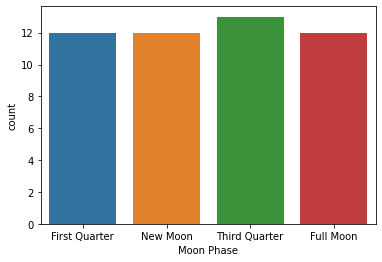

In [23]:
sns.countplot(data=moon_2021, x='Moon Phase')

<AxesSubplot:xlabel='Moon Phase', ylabel='count'>

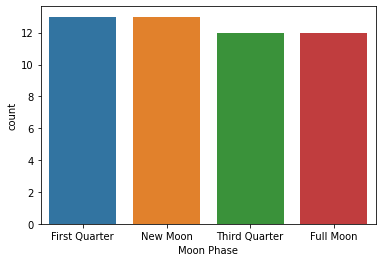

In [24]:
sns.countplot(data=moon_2022, x='Moon Phase')

In [25]:
from altair.utils.data import to_values

alt.Chart.from_dict({
    "data": to_values(moon_2021),
    "mark": "circle",
    "encoding": {
        "x": {
            "field": "Date",
            "type": "temporal",
        },
        "color": {
            "field": "Moon Phase",
            "type": "nominal"
        },
         "y": {
            "field": "Moon Phase",
            "type": "nominal",
        }
    }
})

alt.Chart(...)

In [26]:

alt.Chart.from_dict({
    "data": to_values(moon_2022),
    "mark": "circle",
    "encoding": {
        "x": {
            "field": "Date",
            "type": "temporal",
        },
        "color": {
            "field": "Moon Phase",
            "type": "nominal"
        },
         "y": {
            "field": "Moon Phase",
            "type": "nominal",
        }
    }
})

alt.Chart(...)

In [27]:
alt.Chart.from_dict({
    "data": to_values(combined_moon),
    "mark": "circle",
    "encoding": {
        "x": {
            "field": "Date",
            "type": "temporal",
        },
        "color": {
            "field": "Moon Phase",
            "type": "nominal"
        },
         "y": {
            "field": "Moon Phase",
            "type": "nominal",
        }
    }
})

alt.Chart(...)

## 2. Schlaf-Daten (Fitbit)

### 2.1 Datenaufbereitung

/Users/tamara/GitRepos/chira/cas-datascience-sleep-analysis/cas-data-science-sleep-analysis/cas-datascience-sleep-analysis/cas-data-science-sleep-analysis/raw/heart
False


### 2.2 Fertige Datensätze

### 2.3 Erste Visualisierungen

### Temperature Variation

In [134]:
def importFiles(path):
    all_files = glob.glob(path + "/*.csv")
    li = []
    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)

    return pd.concat(li, axis=0, ignore_index=True)

In [135]:
tempVarPath = r'/Users/tamara/GitRepos/chira/cas-datascience-notebooks/Projektideen/MyFitbitData/Tamara/Sleep/Temperature/' # use your path

tempVarDf = importFiles(tempVarPath)
print(tempVarDf)
print(tempVarDf["temperature"].hist())

NameError: name 'glob' is not defined

### Computed Temperature

In [ ]:
tempVarPath = r'/Users/tamara/GitRepos/chira/cas-datascience-notebooks/Projektideen/MyFitbitData/Tamara/Sleep/Computed Temp/'

tempVarDf = importFiles(tempVarPath)
print("Nightly Temperate ("+str(tempVarDf["nightly_temperature"].count())+") samples")
print(tempVarDf["nightly_temperature"].hist(bins = 50))


from dateutil import parser
import datetime

start = tempVarDf["sleep_start"]
end = tempVarDf["sleep_end"]
time = []

print(start)

for i in range(0, len(start)):    
    # e = datetime.datetime.strptime(end[i], '%y-%m-%dT%H:%M')
    e = parser.parse(end[i])
    # s = datetime.datetime.strptime(start[i],'%y-%m-%ddT%HG:%MM:%S')
    time.append(end[i]-start[i])



# Hilfsfunktionen

## Data Wrangling